We aim to analyze a dataset obtained from HRM using unsupervised classification techniques to categorize and label the data. The dataset primarily focuses on check-in and check-out times. Our objective is to identify a maximum of five potential categories, as speculated below. However, the actual number of optimal clusters will be determined using either the **Elbow Method** or the **Dendrogram Method**.

### Speculated Categories:

*   List item
*   List item


1. Early Check-in, Early Check-out  
2. Early Check-in, Late Check-out  
3. Late Check-in, Late Check-out  
4. Late Check-in, Early Check-out  
5. Average Check-ins  

### Plan:
1. **Unsupervised Clustering**  
   - Use clustering techniques to group the data into the optimal number of clusters.
   - Assign each row to a cluster and label them based on the identified patterns.

2. **Supervised Classification**  
   - Once the dataset is labeled, use it as a training set for supervised machine learning algorithms.
   - Compare different models to determine the one that predicts the categories most accurately.

In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [4]:
# Load the dataset from a CSV file
file_path = 'timesheet_data_dump.csv'
df = pd.read_csv(file_path)
df.head()


,employeeid,in_time,out_time,in_ip,out_ip
0,3416a75f4cea9109507cacd8e2f2aefc,9:14:39,18:41:43,127.0.0.1,110.34.1.29
1,2a38a4a9316c49e5a833517c45d31070,9:32:55,NaN,110.34.1.29,NaN
2,6ea9ab1baa0efb9e19094440c317e21b,10:49:49,NaN,124.41.228.203,NaN
3,6f4922f45568161a8cdf4ad2299f6d23,16:19:14,16:43:41,124.41.228.203,124.41.228.203
4,b53b3a3d6ab90ce0268229151c9bde11,16:44:03,NaN,110.34.1.29,NaN


In [5]:
def time_to_seconds(time_str):
    if pd.isnull(time_str):
        return np.nan
    h, m, s = map(int, time_str.split(':'))
    return h * 3600 + m * 60 + s

df['in_time'] = df['in_time'].apply(time_to_seconds)
df['out_time'] = df['out_time'].apply(time_to_seconds)

# Handle NULLs: Replace with mean for simplicity
df['out_time'] = df['out_time'].fillna(df['out_time'].mean())

In [6]:
# Encode IP addresses
label_encoder_in = LabelEncoder()
label_encoder_out = LabelEncoder()

In [7]:
df['in_ip_encoded'] = label_encoder_in.fit_transform(df['in_ip'])
df['out_ip_encoded'] = label_encoder_out.fit_transform(df['out_ip'].fillna('Unknown'))

In [8]:
# Prepare data for clustering
df_clustering = df[['in_time', 'out_time', 'in_ip_encoded', 'out_ip_encoded']]

In [9]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

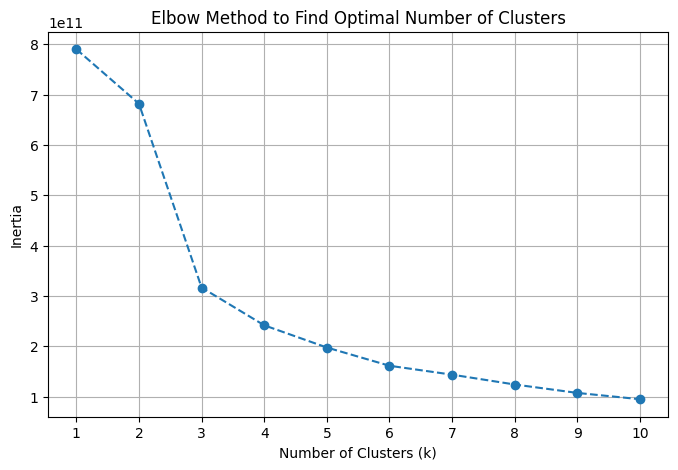

In [10]:
# Determine the optimal number of clusters using the Elbow Method
inertia = []
k_range = range(1, 11)  # Test for 1 to 10 clusters

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_clustering)
    inertia.append(kmeans.inertia_)

# Visualize the Elbow Method
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method to Find Optimal Number of Clusters')
plt.xticks(k_range)
plt.grid()
plt.show()

In [11]:
# Unsupervised Classification: K-Means Clustering
optimal_clusters = 3
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)

# Explicitly assign cluster labels
df_clustering = df_clustering.copy()  # Ensure df_clustering is a copy of the data
df_clustering['cluster'] = kmeans.fit_predict(df_clustering)

In [12]:
# Evaluate clustering with silhouette score
sil_score = silhouette_score(df_clustering.drop('cluster', axis=1), df_clustering['cluster'])

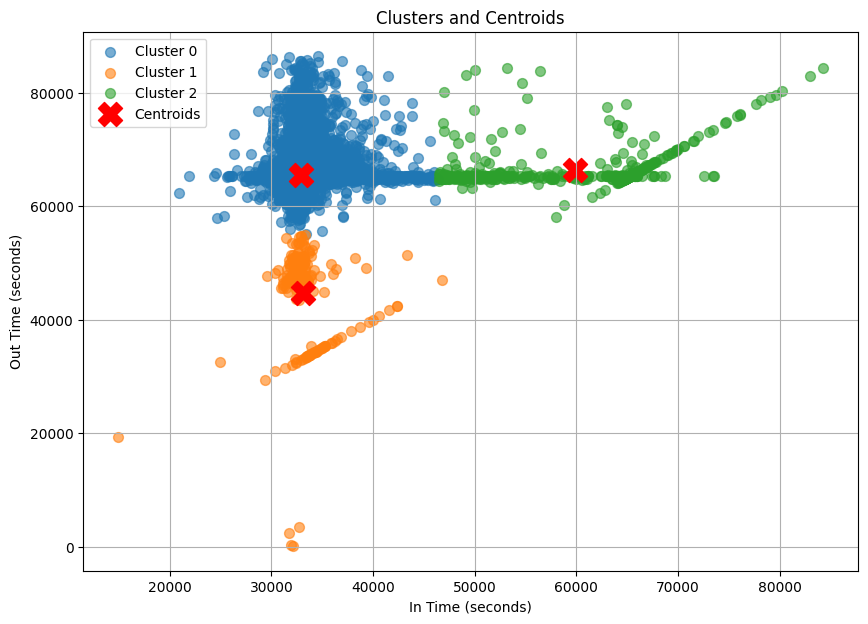

0.8415653815543139

In [18]:
# Visualizing clusters and centroids after KMeans
plt.figure(figsize=(10, 7))

# Scatter plot for clusters
for cluster in range(optimal_clusters):
    cluster_data = df_clustering[df_clustering['cluster'] == cluster]
    plt.scatter(
        cluster_data['in_time'],
        cluster_data['out_time'],
        label=f'Cluster {cluster}',
        s=50,
        alpha=0.6
    )

# Plot centroids
centroids = kmeans.cluster_centers_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    s=300,
    c='red',
    marker='X',
    label='Centroids'
)

# Adding labels and legend
plt.title('Clusters and Centroids')
plt.xlabel('In Time (seconds)')
plt.ylabel('Out Time (seconds)')
plt.legend()
plt.grid(True)
plt.show()

# Display Silhouette Score
sil_score = silhouette_score(df_clustering.drop('cluster', axis=1), df_clustering['cluster'])
sil_score

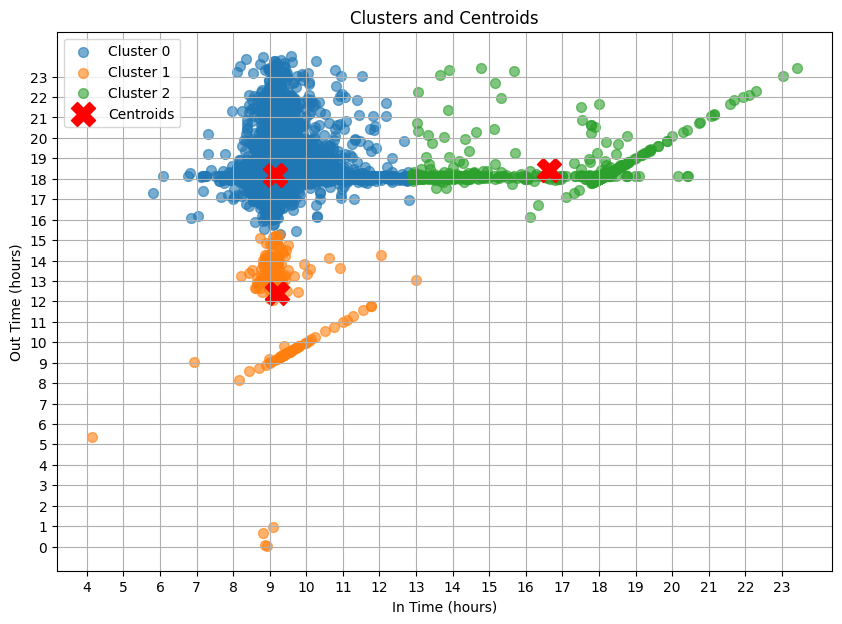

Silhouette Score: 0.8415653840894514


In [20]:
# Convert seconds to hours if not already done
df_clustering['in_time_hours'] = df_clustering['in_time'] / 3600
df_clustering['out_time_hours'] = df_clustering['out_time'] / 3600

# Ensure centroids are in hours
centroids_hours = kmeans.cluster_centers_ / 3600  # Convert to hours

# Visualize clusters
plt.figure(figsize=(10, 7))

for cluster in range(optimal_clusters):
    cluster_data = df_clustering[df_clustering['cluster'] == cluster]
    plt.scatter(
        cluster_data['in_time_hours'],
        cluster_data['out_time_hours'],
        label=f'Cluster {cluster}',
        s=50,
        alpha=0.6
    )

plt.scatter(
    centroids_hours[:, 0],  # Ensure correct indexing
    centroids_hours[:, 1],  # Ensure correct indexing
    s=300,
    c='red',
    marker='X',
    label='Centroids'
)

plt.xticks(range(int(df_clustering['in_time_hours'].min()), int(df_clustering['in_time_hours'].max()) + 1, 1))
plt.yticks(range(int(df_clustering['out_time_hours'].min()), int(df_clustering['out_time_hours'].max()) + 1, 1))

plt.title('Clusters and Centroids')
plt.xlabel('In Time (hours)')
plt.ylabel('Out Time (hours)')
plt.legend()
plt.grid(True)
plt.show()

sil_score = silhouette_score(df_clustering.drop('cluster', axis=1), df_clustering['cluster'])
sil_score
print("Silhouette Score:", sil_score)


In [21]:
# Add the cluster labels to the original dataset
df['cluster'] = df_clustering['cluster']

In [22]:
# Prepare data for supervised learning
X = df[['in_time', 'out_time', 'in_ip_encoded', 'out_ip_encoded']]
y = df['cluster']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [23]:
# Initialize classifiers
classifiers = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=500)
}

In [24]:
# Train and evaluate each model
results = {}
for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    results[name] = accuracy_score(y_test, y_pred)

In [25]:
# Display results
print("Clustering Silhouette Score:", sil_score)
print("Supervised Classification Results:", results)

Clustering Silhouette Score: 0.8415653840894514
Supervised Classification Results: {'Random Forest': 0.9998917514613552, 'SVM': 0.9995670058454211, 'Logistic Regression': 1.0}


In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay

<Figure size 600x600 with 0 Axes>

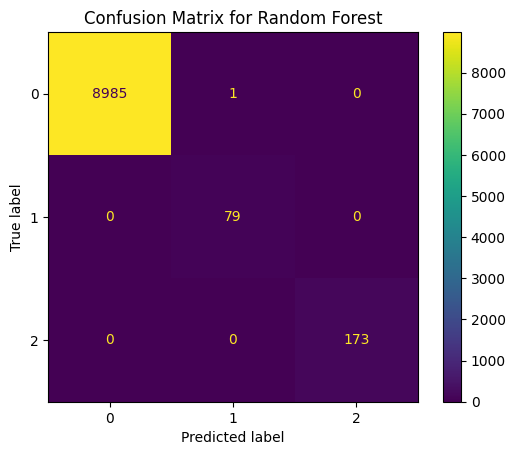

<Figure size 600x600 with 0 Axes>

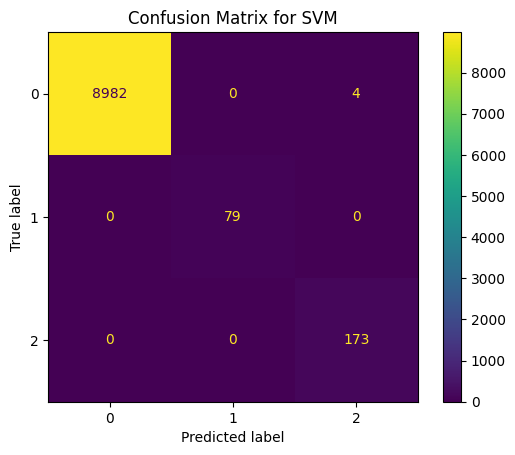

<Figure size 600x600 with 0 Axes>

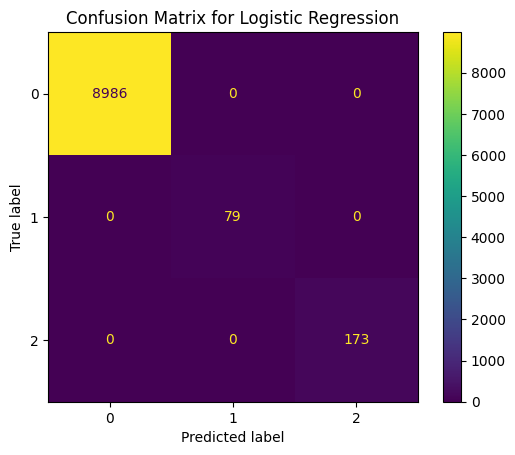

In [27]:
# Train classifiers and store predictions for visualization
predictions = {}
for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    predictions[name] = y_pred

# Visualization of confusion matrices for each classifier
for name, y_pred in predictions.items():
    plt.figure(figsize=(6, 6))
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=[0, 1, 2])
    plt.title(f"Confusion Matrix for {name}")
    plt.show()
